In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras import metrics
from sklearn.preprocessing import MinMaxScaler

In [5]:
df = pd.read_csv('nikkei.csv', encoding="shift_jis")
L = len(df)
Hi = np.array([df.iloc[:, 2]])
Low = np.array([df.iloc[:, 3]])
Close = np.array([df.iloc[:, 4]])
# 入力データ、出力データ作成
Hi = Hi.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）
Low = Low.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）
Close = Close.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）
Hi1 = Hi[0:L-3, :]  # 予測対象日の3日前のデータ
Low1 = Low[0:L-3, :]  # 予測対象日の3日前のデータ
Close1 = Close[0:L-3, :]  # 予測対象日の3日前のデータ
Hi2 = Hi[1:L-2, :]  # 予測対象日の2日前のデータ
Low2 = Low[1:L-2, :]  # 予測対象日の2日前のデータ
Close2 = Close[1:L-2, :]  # 予測対象日の2日前のデータ
Hi3 = Hi[2:L-1, :]  # 予測対象日の前日データ
Low3 = Low[2:L-1, :]  # 予測対象日の前日のデータ
Close3 = Close[2:L-1, :]  # 予測対象日の前日のデータ
X = np.concatenate([Low1, Hi1, Close1, Low2, Hi2, Close2, Low3, Hi3, Close3], axis=1)
Y = Close[3:L, :]  # 予測対象日のデータ
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler1 = MinMaxScaler()
scaler1.fit(Y)
Y = scaler1.transform(Y)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
print(X.shape)
X_train = X[:190, :, :]
X_test = X[190:, :, :]
Y_train = Y[:190, :]
Y_test = Y[190:, :]


(237, 1, 9)


In [6]:
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(1, 9), recurrent_activation='hard_sigmoid'))
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation=LeakyReLU(alpha=0.02)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [7]:
model.fit(X_train, Y_train, epochs=80, batch_size=12, verbose=2)
Predict = model.predict(X_test, verbose=1)

Epoch 1/80
16/16 - 2s - loss: 0.0447 - mean_absolute_error: 0.1465
Epoch 2/80
16/16 - 0s - loss: 0.0102 - mean_absolute_error: 0.0774
Epoch 3/80
16/16 - 0s - loss: 0.0083 - mean_absolute_error: 0.0719
Epoch 4/80
16/16 - 0s - loss: 0.0091 - mean_absolute_error: 0.0736
Epoch 5/80
16/16 - 0s - loss: 0.0083 - mean_absolute_error: 0.0726
Epoch 6/80
16/16 - 0s - loss: 0.0080 - mean_absolute_error: 0.0676
Epoch 7/80
16/16 - 0s - loss: 0.0086 - mean_absolute_error: 0.0712
Epoch 8/80
16/16 - 0s - loss: 0.0076 - mean_absolute_error: 0.0655
Epoch 9/80
16/16 - 0s - loss: 0.0078 - mean_absolute_error: 0.0694
Epoch 10/80
16/16 - 0s - loss: 0.0084 - mean_absolute_error: 0.0694
Epoch 11/80
16/16 - 0s - loss: 0.0069 - mean_absolute_error: 0.0663
Epoch 12/80
16/16 - 0s - loss: 0.0068 - mean_absolute_error: 0.0654
Epoch 13/80
16/16 - 0s - loss: 0.0066 - mean_absolute_error: 0.0637
Epoch 14/80
16/16 - 0s - loss: 0.0067 - mean_absolute_error: 0.0650
Epoch 15/80
16/16 - 0s - loss: 0.0065 - mean_absolute_err

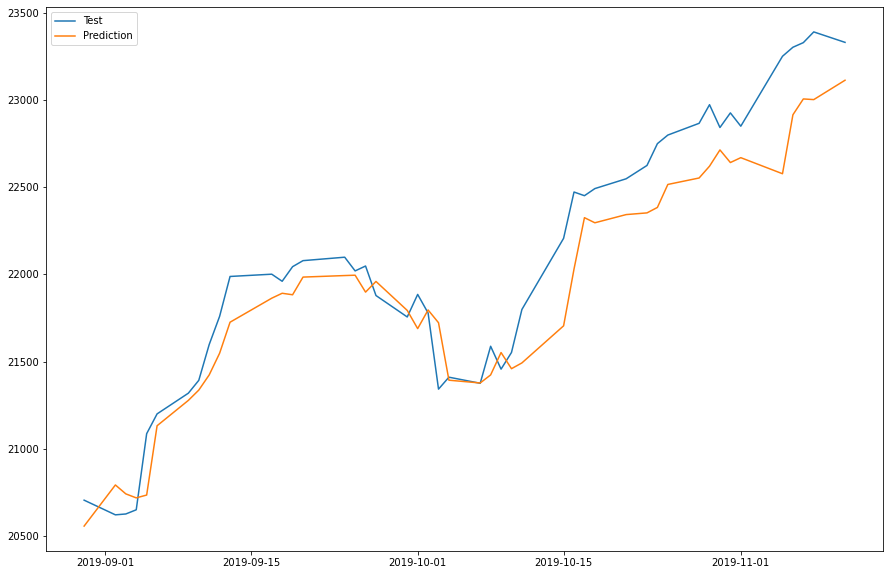

In [8]:
## オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(df.iloc[3:193,0])
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(df.iloc[193:,0])
Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)
Predict.index=pd.to_datetime(df.iloc[193:,0])
plt.figure(figsize=(15,10))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()